In [58]:
import pubchempy as pcp
from rdkit import Chem 
from rdkit.Chem import Draw
import pandas as pd
from IPython.display import display, Image
from rdkit.Chem import Fragments
from rdkit.Chem.Draw import IPythonConsole

## Definições de padrões SMARTS para diferentes grupos funcionais

In [4]:
functional_groups = {
    'Álcool primário': '[$([C;!$(C=O);$([C;H2][OH]),$([C;H3][OH])])]',  # Grupo hidroxila ligado a um carbono 
    'Álcool secundário': '[$([#6;!$(C=O);$([#6;H1][OH]),$([#6;H0][OH])])]',  # Grupo hidroxila ligado a um carbono 
    'Álcool terciário':'[$([C;!$(C=O);$([C;H0][OH])])]', # Grupo hidroxila ligado a um carbono
    'Aldeído': '[$([C;H]=O),$([C;H2]=O);!$([C][OH]);!$([C][N]);!$([C][O])]',  # Carbono duplamente ligado a oxigênio e ligado a um hidrogênio
    'Cetona': '[#6][CX3](=O)[#6]',  # Carbono duplamente ligado a oxigênio e ligado a dois carbonos
    'Ácido carboxílico': '[$([CX3](=O)[OX2H1])]',  # Carbono duplamente ligado a oxigênio e ligado a um grupo hidroxila
    'Éster': '[$([#6](=O)[OX2][#6;!$(C=O)])]',  # Carbono duplamente ligado a oxigênio e ligado a um oxigênio ligado a outro carbono
    'Anidrido': '[#6](=[OX1])[OX2][#6](=[OX1])',  # Grupo anidrido
    'Amina primária': '[$([N;H2;!$(NC=O)])]',  # Nitrogênio ligado a um carbono  e dois hidrogênios
    'Amina secundária': '[N;H1;!$(NC=O);!$(N(C)C=O)]',  # Nitrogênio ligado a um carbono e um hidrogênio
    'Amina terciária': '[$([N;H0;!$(NC=O);!$(N(C)C=O);!$(N(C)(C)C=O);!$(N#C);!$(N=C);!$([N+](=O)[O-])])]',  # Nitrogênio ligado a três carbonos
    'Amida primária': '[CX3](=O)[NX3H2]',
    'Amida secundária': '[CX3](=O)[NX3H1][CX4]',
    'Amida terciária': '[CX3](=O)[NX3]([CX4])[CX4]',
    'Éter': '[#6;!$(C=O)]-O-[#6;!$(C=O)]',  # Oxigênio ligado a dois carbonos
    'Haleto de alquila': '[#6][F,Cl,Br,I]',  # Halogênio ligado a um carbono 
    'Tiol': '[#6][SH]',  # Grupo tiol
    'Tioéter': '[#6;!$(C=O)]-S-[#6;!$(C=O)]', # Enxofre ligado a dois carbonos 
    'Alceno':'[#6]=[#6]', # Ligação dupla carbono-carbono
    'Alcino': '[#6]#[#6]',  # Tripla ligação carbono-carbono
    'Anel aromático': 'c1ccccc1',  # Qualquer átomo em um anel aromático
    'Nitrila': '[#6]#N',  # Tripla ligação carbono-nitrogênio
    'Peróxido': '[OX2][OX2]',  # Grupo peróxido
    'Isocianato': '[NX2]=[CX2]=[OX1]',  # Grupo isocianato
    'Isotiocianato': '[NX2]=[CX2]=[SX1]',  # Grupo isotiocianato
    'Fosfina': '[PX3]',  # Grupo fosfina
    'Nitro': '[N+](=O)[O-]',  # Grupo nitro
    'Fosfato': 'O=P(O)(O)O',  # Grupo fosfato
}


In [5]:
def identify_functional_groups(smiles):
    mol2 = Chem.MolFromSmiles(smiles)
    if mol2 is None:
        raise ValueError("Invalid SMILES string")
    
    identified_groups = {}
    
    for group_name, smarts in functional_groups.items():
        patt = Chem.MolFromSmarts(smarts)
        if mol2.HasSubstructMatch(patt):
            identified_groups[group_name] = mol2.GetSubstructMatches(patt)
    
    return identified_groups

In [6]:
def create_functional_groups_dataframe(identified_groups):
    group_counts = {group: len(matches) for group, matches in identified_groups.items()}
    df = pd.DataFrame(list(group_counts.items()), columns=['Função Orgânica', 'Quantidade'])
    return df

Exemplo de como identificar os grupos funcoinais

((3, 4, 5), (8, 9, 7))


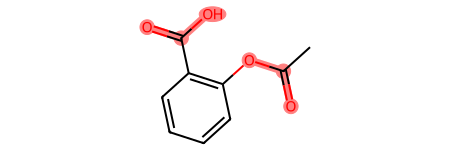

In [60]:
m = Chem.MolFromSmiles('c1cc(C(=O)O)c(OC(=O)C)cc1')
substructure = Chem.MolFromSmarts('C(=O)O')
print(m.GetSubstructMatches(substructure))
m

In [7]:
def draw_molecule_with_functional_groups(smiles):
    mol = Chem.MolFromSmiles(smiles)
    drawer = Draw.rdMolDraw2D.MolDraw2DCairo(500, 500)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    
    mol2 = Chem.MolFromSmiles(smiles)
    if mol2 is None:
        raise ValueError("Invalid SMILES string")

    
    identified_groups = identify_functional_groups(smiles)
    drawer2 = Draw.rdMolDraw2D.MolDraw2DCairo(500, 500)
    opts = drawer2.drawOptions()
    
    highlight_atoms = []
    highlight_bonds = []
    highlight_colors = {}

    color_palette = [
        (1.0, 1.0, 0.0),  # Yellow
        (0.3, 1.0, 0.0),  # Green
        (0.2, 0.6, 1.0),  # Light Blue
        (1.0, 0.5, 0.0),  # Orange
        (1.0, 0.5, 1.0),  # Magenta
        (0.0, 1.0, 1.0),  # Cyan
    ]
    
    color_idx = 0
    
    for group_name, matches in identified_groups.items():
        color = color_palette[color_idx % len(color_palette)]
        color_idx += 1
        for match in matches:
            highlight_atoms.extend(list(match))
            highlight_colors.update({i: color for i in match})
            # Add bonds to the highlight list
            for i in range(len(match) - 1):
                bond = mol2.GetBondBetweenAtoms(match[i], match[i+1])
                if bond is not None:
                    highlight_bonds.append(bond.GetIdx())
            # Ensure to add the last bond in the functional group
            if len(match) > 2:
                bond = mol2.GetBondBetweenAtoms(match[-1], match[0])
                if bond is not None:
                    highlight_bonds.append(bond.GetIdx())
    
    drawer2.DrawMolecule(
        mol2,
        highlightAtoms=highlight_atoms,
        highlightBonds=highlight_bonds,
        
        highlightAtomColors=highlight_colors,
    )
    drawer2.FinishDrawing()
    return drawer.GetDrawingText(), drawer2.GetDrawingText()

### Carregar alguns SMILES para verificar a identificação dos grupos funcionais

In [53]:
dados = pd.read_csv('dados.txt', sep=',')
dados.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [36]:
smiles_data = dados["SMILES"].astype(str)
smiles_data = smiles_data[0:5]
smiles_data

0         ClCC(Cl)(Cl)Cl
1           CC(Cl)(Cl)Cl
2         ClC(Cl)C(Cl)Cl
3             ClCC(Cl)Cl
4    FC(F)(Cl)C(F)(Cl)Cl
Name: SMILES, dtype: object

Nome: 1,1,1,2-Tetrachloroethane
Fórmula molecular: C2H2Cl4
Massa molar: 167.8 g/mol



,Função Orgânica,Quantidade
0,Haleto de alquila,4


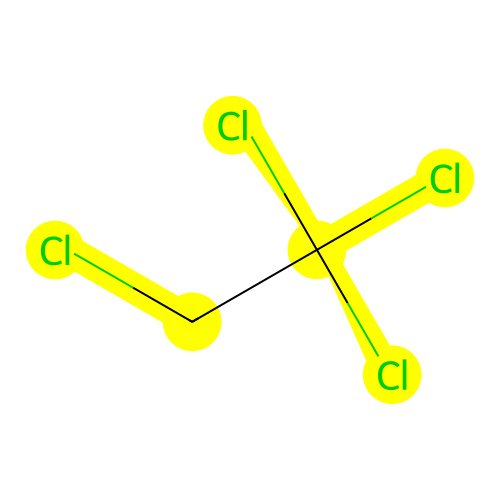

Nome: 1,1,1-Trichloroethane
Fórmula molecular: C2H3Cl3
Massa molar: 133.40 g/mol



,Função Orgânica,Quantidade
0,Haleto de alquila,3


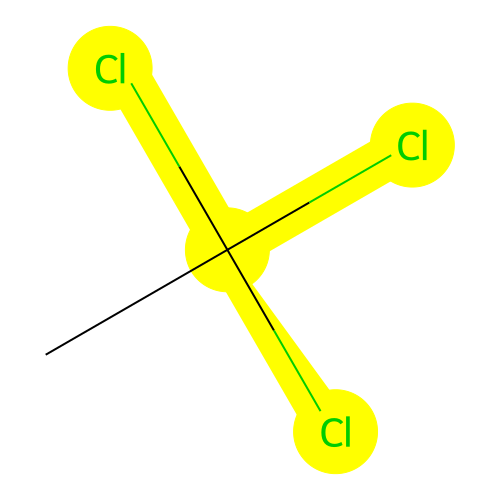

Nome: 1,1,2,2-Tetrachloroethane
Fórmula molecular: C2H2Cl4
Massa molar: 167.8 g/mol



,Função Orgânica,Quantidade
0,Haleto de alquila,4


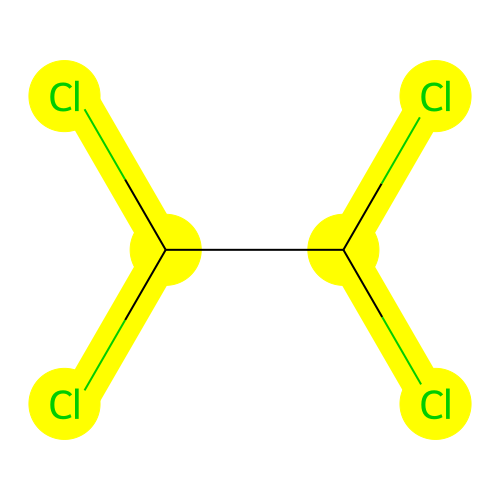

Nome: 1,1,2-Trichloroethane
Fórmula molecular: C2H3Cl3
Massa molar: 133.40 g/mol



,Função Orgânica,Quantidade
0,Haleto de alquila,3


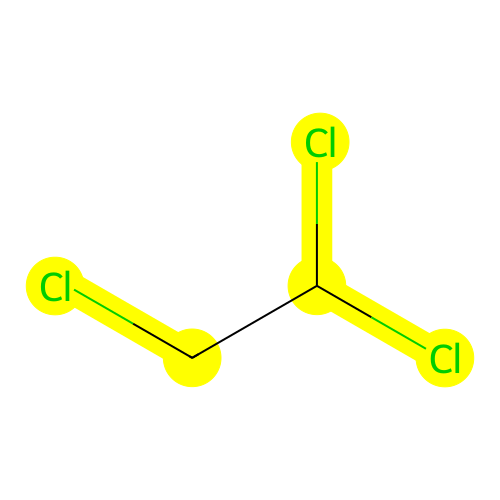

Nome: 1,1,2-Trichlorotrifluoroethane
Fórmula molecular: C2Cl3F3
Massa molar: 187.37 g/mol



,Função Orgânica,Quantidade
0,Haleto de alquila,6


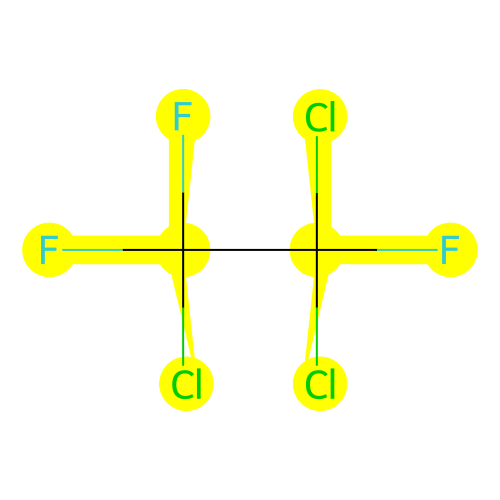

In [57]:
for smiles in smiles_data:
    
    # Obter CID a partir do SMILES
    cid = pcp.get_compounds(smiles, 'smiles')
    c = pcp.Compound.from_cid(cid[0].cid)
    
    # Extrair nome da molécula
    name = dados['Compound ID'][dados['SMILES']==smiles].values[0]
    print("Nome:", name)
    print('Fórmula molecular: ' + c.molecular_formula)
    print('Massa molar: ' + c.molecular_weight + ' g/mol\n')
    
    # Identificar grupos e desenhar moleculas
    identified_groups = identify_functional_groups(smiles)
    img_data,img_data_groups = draw_molecule_with_functional_groups(smiles)
    
    # Criar DataFrame para contar os grupos identificados
    df = create_functional_groups_dataframe(identified_groups)
    display(df)

    display(Image(img_data_groups))